In [58]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.python.ops.control_flow_ops import from_control_flow_context_def

In [32]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k_v1", url,
                                    untar=True, cache_dir='stack_overflow',
                                    cache_subdir='.')
dataset_dir = os.path.join(os.path.dirname(dataset))

In [33]:
os.listdir(dataset_dir)

['README.md', 'stack_overflow_16k_v1.tar.gz', 'test', 'train']

In [34]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['csharp', 'java', 'javascript', 'python']

melihat sample data

In [35]:
sample_file = os.path.join(train_dir, 'python/12.txt')
with open(sample_file) as f:
  print(f.read())

"trouble with self keyword in blank am creating a browser in ubuntu.. using glade.when i compile it's showing ""nameerror: name 'self' is not defined"".code :  ..self.reload = self.bulider.get_object(""reload"").def on_pressbutton_clicked(self, widget): print""reload""...it is just a sample code to check button's action.."



membuat data latih

In [36]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


mengecek kelas target

In [37]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


membuat data validation

In [38]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size = batch_size,
    validation_split=0.2,
    subset='validation',
    seed = seed
)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


membuat data test

In [41]:
test_dir = os.path.join(dataset_dir, 'test')
os.listdir(test_dir)

['csharp', 'java', 'javascript', 'python']

In [42]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir, 
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


standarisasi data text

In [43]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [44]:
max_size_vocab = 10000
max_sequence_length = 250
binary_vectorize_layer = layers.TextVectorization(
    max_tokens=max_size_vocab,
    output_mode='binary')

membuat layer untuk vektorisasi

In [45]:
int_vectorize_layer = layers.TextVectorization(
  max_tokens=max_size_vocab,
  output_mode='int',
  output_sequence_length=max_sequence_length)

fit binary vectorization dan int vectorization pada data train

In [46]:
train_text = raw_train_ds.map(lambda text, labels: text)
binary_vectorize_layer.adapt(train_text)
int_vectorize_layer.adapt(train_text)

functionn untuk preprocessing

In [48]:
def binary_vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return binary_vectorize_layer(text), label
def int_vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return int_vectorize_layer(text), label

mengecek hasil preprocessing

In [53]:
text_batch, label_batch = next(iter(raw_train_ds))
print("Question", text_batch.numpy()[0])
print("language", label_batch.numpy()[0])
print("Binary Vectorized QA", binary_vectorize_text(text_batch.numpy()[0], label_batch.numpy()[0]))
print("Int Vectorized QA", int_vectorize_text(text_batch.numpy()[0], label_batch.numpy()[0]))

Question b'"what is the difference between these two ways to create an element? var a = document.createelement(\'div\');..a.id = ""mydiv"";...and..var a = document.createelement(\'div\').id = ""mydiv"";...what is the difference between them such that the first one works and the second one doesn\'t?"\n'
language 2
Binary Vectorized QA (<tf.Tensor: shape=(1, 10000), dtype=int64, numpy=array([[1, 1, 0, ..., 0, 0, 0]], dtype=int64)>, 2)
Int Vectorized QA (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[ 55,   6,   2, 410, 211, 229, 121, 895,   4, 124,  32, 245,  43,
          5,   1,   1,   5,   1,   1,   6,   2, 410, 211, 191, 318,  14,
          2,  98,  71, 188,   8,   2, 199,  71, 178,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 

apply preprocessing ke data train, test, dan val

In [54]:
binary_train_ds = raw_train_ds.map(binary_vectorize_text)
binary_val_ds = raw_val_ds.map(binary_vectorize_text)
binary_test_ds = raw_test_ds.map(binary_vectorize_text)
int_train_ds = raw_train_ds.map(int_vectorize_text)
int_val_ds = raw_val_ds.map(int_vectorize_text)
int_test_ds = raw_test_ds.map(int_vectorize_text)

konfigurasi dataset dengan autotune untuk otomatisasi menentukan ukuran buffer yang optimal untuk prefetching

In [55]:
AUTOTUNE = tf.data.AUTOTUNE

binary_train_ds = binary_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
binary_val_ds = binary_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
binary_test_ds = binary_test_ds.cache().prefetch(buffer_size=AUTOTUNE)
int_train_ds = int_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
int_val_ds = int_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
int_test_ds = int_test_ds.cache().prefetch(buffer_size=AUTOTUNE)


## membuat base model (model linear)

In [144]:
binary_model = tf.keras.Sequential([
  layers.Dense(4)
])
binary_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),optimizer='adamax',metrics=['accuracy']
)
history = binary_model.fit(
    binary_train_ds,validation_data=binary_val_ds, epochs=10
)

Epoch 1/10


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4538 - loss: 1.3120 - val_accuracy: 0.6850 - val_loss: 1.1399
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7432 - loss: 1.0817 - val_accuracy: 0.7394 - val_loss: 1.0023
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7774 - loss: 0.9504 - val_accuracy: 0.7531 - val_loss: 0.9073
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7899 - loss: 0.8569 - val_accuracy: 0.7656 - val_loss: 0.8379
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8008 - loss: 0.7866 - val_accuracy: 0.7731 - val_loss: 0.7850
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8129 - loss: 0.7316 - val_accuracy: 0.7806 - val_loss: 0.7437
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8244 - loss: 0.6874 - val_accuracy: 0.7881 - val_loss: 0.7106
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8304 - loss: 0.6510 - val_accuracy: 0.7944 - val_

plot hasil pemodelan

In [119]:
def plot_training_history(history):
  history_dict = history.history
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']
  epochs = range(1, len(acc) + 1)

  plt.figure(figsize=(8, 5))  # Set plot figure size (optional)

  plt.plot(epochs, acc, 'bo', label='Training Accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')

  plt.plot(epochs, loss, 'ro', label='Training Loss')
  plt.plot(epochs, val_loss, 'r', label='Validation Loss')
  plt.title('Training and Validation Loss and Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(loc='upper right')  # Separate legend for loss plots

  plt.show()


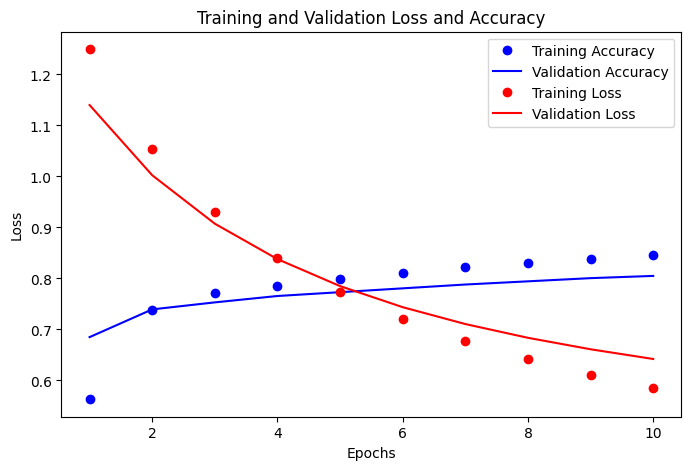

In [145]:
plot_training_history(history=history)

## membuat model cnn

In [146]:
def create_model(vocab_size, num_labels):
  model = tf.keras.Sequential([
    layers.Embedding(vocab_size, 64, mask_zero=True),
    layers.Dropout(0.2),
    layers.Conv1D(64, 5, padding="valid", activation="relu", strides=2),
    layers.GlobalMaxPooling1D(),
    layers.Dropout(0.2), 
    layers.Dense(num_labels)
    ])
  return model

int_model = create_model(vocab_size=max_size_vocab + 1, num_labels=4)
int_model.compile(
  loss=losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy'])
history = int_model.fit(int_train_ds, validation_data=int_val_ds,epochs=10)

Epoch 1/10


c:\Users\Mufajar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\layer.py:847: UserWarning: Layer 'conv1d_3' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.3532 - loss: 1.3252 - val_accuracy: 0.6687 - val_loss: 0.8135
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6830 - loss: 0.7801 - val_accuracy: 0.7669 - val_loss: 0.5989
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8058 - loss: 0.5414 - val_accuracy: 0.8012 - val_loss: 0.5177
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8810 - loss: 0.3683 - val_accuracy: 0.8056 - val_loss: 0.4918
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9281 - loss: 0.2527 - val_accuracy: 0.8125 - val_loss: 0.5003
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9561 - loss: 0.1690 - val_accuracy: 0.8094 - val_loss: 0.5318
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9744 - loss: 0.1096 - val_accuracy: 0.8100 - val_loss: 0.5726
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9864 - loss: 0.0698 - val_accuracy: 0.811

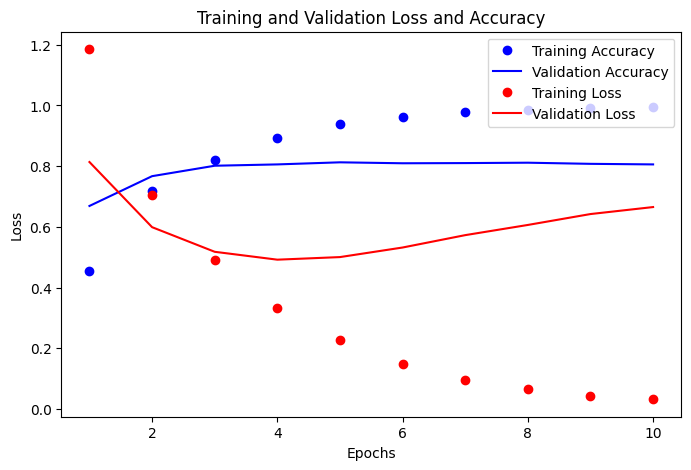

In [148]:
plot_training_history(history=history)

ringkasan dari linear model dan cnn model

In [149]:
print("Linear model on binary vectorized data:")
print(binary_model.summary())

Linear model on binary vectorized data:


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 4)              │        40,004 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,014 (468.81 KB)

 Trainable params: 40,004 (156.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 80,010 (312.54 KB)

None


In [125]:
print("Conventional model on integer vectorized data:")
print(int_model.summary())

Conventional model on integer vectorized data:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, None, 64)       │       640,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, None, 64)       │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,982,606 (7.56 MB)

 Trainable params: 660,868 (2.52 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,321,738 (5.04 MB)

None


mengecek pada data test

In [126]:
binary_loss, binary_accuracy = binary_model.evaluate(binary_test_ds)
int_loss, int_accuracy, = int_model.evaluate(int_test_ds)
print("Binary model accuracy : {:2.2%}".format(binary_accuracy))
print("Integer model accuracy : {:2.2%}".format(int_accuracy))

 26/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8068 - loss: 0.5007

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8164 - loss: 0.4948
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8036 - loss: 0.6374
Binary model accuracy : 81.30%
Integer model accuracy : 80.21%


export the model

In [150]:
export_model = tf.keras.Sequential([
  int_vectorize_layer, int_model,
  layers.Activation('sigmoid')])
  
export_model.compile(
  loss=losses.SparseCategoricalCrossentropy(from_logits=False),optimizer='adam',metrics=['accuracy'])

loss, accuracy = export_model.evaluate(raw_test_ds)
print("Accuracy: {:2.2%}".format(binary_accuracy))

c:\Users\Mufajar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\layer.py:847: UserWarning: Layer 'conv1d_3' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8083 - loss: 0.6294
Accuracy: 81.30%


mengetes dengan data baru

In [151]:
def get_string_labels(predicted_scores_batch):
  predicted_int_labels = tf.argmax(predicted_scores_batch, axis=1)
  predicted_labels = tf.gather(raw_train_ds.class_names,
                               predicted_int_labels)
  return predicted_labels

In [152]:
inputs = tf.constant([
       "How can you debug and address a MemoryError when training a large neural network?", 
       "How can you write a well-structured and customizable utility function?",
       "How can you create a custom exception handling mechanism?",
       "ow can you design and implement a custom data structure? "
       ])

predicted_scores = export_model.predict(inputs)
predicted_labels = get_string_labels(predicted_scores)

for input, label in zip(inputs, predicted_labels):
  print("Question: ", input)
  print("Predicted label: ", label.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
Question:  tf.Tensor(b'How can you debug and address a MemoryError when training a large neural network?', shape=(), dtype=string)
Predicted label:  b'java'
Question:  tf.Tensor(b'How can you write a well-structured and customizable utility function?', shape=(), dtype=string)
Predicted label:  b'javascript'
Question:  tf.Tensor(b'How can you create a custom exception handling mechanism?', shape=(), dtype=string)
Predicted label:  b'csharp'
Question:  tf.Tensor(b'ow can you design and implement a custom data structure? ', shape=(), dtype=string)
Predicted label:  b'csharp'
